# Parameter Identification Technique (PIT) on static VCT with a linear VMM model

# Purpose
Is it possible to use a similar regression as used in [04.02_PIT_linear_VMM.ipynb](04.02_PIT_linear_VMM.ipynb) but with data from static Virtual Captive Tests (VCT)?

# Methodology
* Load static data from VCT
* Find the best parameter values in the linear model using OLS linear regression.

# Setup

In [3]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
from src.models import linear_vmm
import src.linear_vmm_equations as eq
import src.models.linear_vmm as model
from src.symbols import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.plot import track_plot


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


## Load VCT data

In [4]:
df_VCT_all = pd.read_csv('../data/external/vct.csv', index_col=0)
df_VCT_all.head()

,level_0,Dp,S,S_Xgrid,S_inner_bracket_port,S_inner_bracket_stb,S_outer_bracket_port,S_outer_bracket_stb,S_rudder_port,S_rudder_stb,S_shaft_port_assembly,S_shaft_port_shaft1,S_shaft_port_shaft2,S_shaft_stb_assembly,S_shaft_stb_shaft1,S_shaft_stb_shaft2,V,beta,delta,fx,fx_Xgrid,fx_inner_bracket_port,fx_inner_bracket_stb,fx_outer_bracket_port,fx_outer_bracket_stb,fx_rudder_port,fx_rudder_stb,fx_shaft_port_assembly,fx_shaft_port_shaft1,fx_shaft_port_shaft2,fx_shaft_stb_assembly,fx_shaft_stb_shaft1,fx_shaft_stb_shaft2,fy,fy_Xgrid,fy_inner_bracket_port,fy_inner_bracket_stb,fy_outer_bracket_port,fy_outer_bracket_stb,fy_rudder_port,fy_rudder_stb,fy_shaft_port_assembly,fy_shaft_port_shaft1,fy_shaft_port_shaft2,fy_shaft_stb_assembly,fy_shaft_stb_shaft1,fy_shaft_stb_shaft2,fz,fz_Xgrid,fz_inner_bracket_port,fz_inner_bracket_stb,fz_outer_bracket_port,fz_outer_bracket_stb,fz_rudder_port,fz_rudder_stb,fz_shaft_port_assembly,fz_shaft_port_shaft1,fz_shaft_port_shaft2,fz_shaft_stb_assembly,fz_shaft_stb_shaft1,fz_shaft_stb_shaft2,g,lpp,mx,mx_Xgrid,mx_inner_bracket_port,mx_inner_bracket_stb,mx_outer_bracket_port,mx_outer_bracket_stb,mx_rudder_port,mx_rudder_stb,mx_shaft_port_assembly,mx_shaft_port_shaft1,mx_shaft_port_shaft2,mx_shaft_stb_assembly,mx_shaft_stb_shaft1,mx_shaft_stb_shaft2,my,my_Xgrid,my_inner_bracket_port,my_inner_bracket_stb,my_outer_bracket_port,my_outer_bracket_stb,my_rudder_port,my_rudder_stb,my_shaft_port_assembly,my_shaft_port_shaft1,my_shaft_port_shaft2,my_shaft_stb_assembly,my_shaft_stb_shaft1,my_shaft_stb_shaft2,mz,mz_Xgrid,mz_inner_bracket_port,mz_inner_bracket_stb,mz_outer_bracket_port,mz_outer_bracket_stb,mz_rudder_port,mz_rudder_stb,mz_shaft_port_assembly,mz_shaft_port_shaft1,mz_shaft_port_shaft2,mz_shaft_stb_assembly,mz_shaft_stb_shaft1,mz_shaft_stb_shaft2,r,result_file_path,rho,u,v,name,path,thrust,rev,p,phi,model_name,S_BK_port1,S_BK_stb1,fx_BK_port1,fx_BK_stb1,fy_BK_port1,fy_BK_stb1,fz_BK_port1,fz_BK_stb1,mx_BK_port1,mx_BK_stb1,my_BK_port1,my_BK_stb1,mz_BK_port1,mz_BK_stb1,S_daggerboard_middle,fx_daggerboard_middle,fy_daggerboard_middle,fz_daggerboard_middle,mx_daggerboard_middle,my_daggerboard_middle,mz_daggerboard_middle,S_R4083_ref,fx_R4083_ref,fy_R4083_ref,fz_R4083_ref,mx_R4083_ref,my_R4083_ref,mz_R4083_ref,S_Rudder_Center,S_Rudder_Port,S_Rudder_Starboard,S_hull,S_rudder,fx_Rudder_Center,fx_Rudder_Port,fx_Rudder_Starboard,fx_hull,fx_rudder,fy_Rudder_Center,fy_Rudder_Port,fy_Rudder_Starboard,fy_hull,fy_rudder,fz_Rudder_Center,fz_Rudder_Port,fz_Rudder_Starboard,fz_hull,fz_rudder,mx_Rudder_Center,mx_Rudder_Port,mx_Rudder_Starboard,mx_hull,mx_rudder,my_Rudder_Center,my_Rudder_Port,my_Rudder_Starboard,my_hull,my_rudder,mz_Rudder_Center,mz_Rudder_Port,mz_Rudder_Starboard,mz_hull,mz_rudder,torque,test type,eta0,eta0_round,fx_rudders,fy_rudders,fz_rudders,mx_rudders,my_rudders,mz_rudders,clr,S_daggerboard_port,S_daggerboard_stb,fake_index,fx_daggerboard_port,fx_daggerboard_stb,fy_daggerboard_port,fy_daggerboard_stb,fz_daggerboard_port,fz_daggerboard_stb,mx_daggerboard_port,mx_daggerboard_stb,my_daggerboard_port,my_daggerboard_stb,mz_daggerboard_port,mz_daggerboard_stb,$\frac{fx}{V^2}$,$\frac{fy}{V^2}$,$\frac{mz}{V^2}$
0,165,7.3,7375.872,7277.256591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.173333,0.0,-0.000000,-261193.992917,-252076.078409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1308.975604,-295.088406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.879028e+06,-5.881622e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.80665,196.0,5.778834e+02,-1085.233044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.173220e+08,6.178902e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.236840e+05,2.386122e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,L:\proj2019\40199079-Segelfartyg-Wallenius\VCT...,1025.0,6.173333,-0.0,12knotsResistance,L:\proj2019\40199079-Segelfartyg-Wallenius\VCT...,0.0,0.0,0,0,HERO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.61946

In [5]:
df_VCT = df_VCT_all.groupby(by=['model_name']).get_group('V2_5_MDL_modelScale')

In [6]:
df_VCT.describe()

,level_0,Dp,S,S_Xgrid,S_inner_bracket_port,S_inner_bracket_stb,S_outer_bracket_port,S_outer_bracket_stb,S_rudder_port,S_rudder_stb,S_shaft_port_assembly,S_shaft_port_shaft1,S_shaft_port_shaft2,S_shaft_stb_assembly,S_shaft_stb_shaft1,S_shaft_stb_shaft2,V,beta,delta,fx,fx_Xgrid,fx_inner_bracket_port,fx_inner_bracket_stb,fx_outer_bracket_port,fx_outer_bracket_stb,fx_rudder_port,fx_rudder_stb,fx_shaft_port_assembly,fx_shaft_port_shaft1,fx_shaft_port_shaft2,fx_shaft_stb_assembly,fx_shaft_stb_shaft1,fx_shaft_stb_shaft2,fy,fy_Xgrid,fy_inner_bracket_port,fy_inner_bracket_stb,fy_outer_bracket_port,fy_outer_bracket_stb,fy_rudder_port,fy_rudder_stb,fy_shaft_port_assembly,fy_shaft_port_shaft1,fy_shaft_port_shaft2,fy_shaft_stb_assembly,fy_shaft_stb_shaft1,fy_shaft_stb_shaft2,fz,fz_Xgrid,fz_inner_bracket_port,fz_inner_bracket_stb,fz_outer_bracket_port,fz_outer_bracket_stb,fz_rudder_port,fz_rudder_stb,fz_shaft_port_assembly,fz_shaft_port_shaft1,fz_shaft_port_shaft2,fz_shaft_stb_assembly,fz_shaft_stb_shaft1,fz_shaft_stb_shaft2,g,lpp,mx,mx_Xgrid,mx_inner_bracket_port,mx_inner_bracket_stb,mx_outer_bracket_port,mx_outer_bracket_stb,mx_rudder_port,mx_rudder_stb,mx_shaft_port_assembly,mx_shaft_port_shaft1,mx_shaft_port_shaft2,mx_shaft_stb_assembly,mx_shaft_stb_shaft1,mx_shaft_stb_shaft2,my,my_Xgrid,my_inner_bracket_port,my_inner_bracket_stb,my_outer_bracket_port,my_outer_bracket_stb,my_rudder_port,my_rudder_stb,my_shaft_port_assembly,my_shaft_port_shaft1,my_shaft_port_shaft2,my_shaft_stb_assembly,my_shaft_stb_shaft1,my_shaft_stb_shaft2,mz,mz_Xgrid,mz_inner_bracket_port,mz_inner_bracket_stb,mz_outer_bracket_port,mz_outer_bracket_stb,mz_rudder_port,mz_rudder_stb,mz_shaft_port_assembly,mz_shaft_port_shaft1,mz_shaft_port_shaft2,mz_shaft_stb_assembly,mz_shaft_stb_shaft1,mz_shaft_stb_shaft2,r,rho,u,v,thrust,rev,p,phi,S_BK_port1,S_BK_stb1,fx_BK_port1,fx_BK_stb1,fy_BK_port1,fy_BK_stb1,fz_BK_port1,fz_BK_stb1,mx_BK_port1,mx_BK_stb1,my_BK_port1,my_BK_stb1,mz_BK_port1,mz_BK_stb1,S_daggerboard_middle,fx_daggerboard_middle,fy_daggerboard_middle,fz_daggerboard_middle,mx_daggerboard_middle,my_daggerboard_middle,mz_daggerboard_middle,S_R4083_ref,fx_R4083_ref,fy_R4083_ref,fz_R4083_ref,mx_R4083_ref,my_R4083_ref,mz_R4083_ref,S_Rudder_Center,S_Rudder_Port,S_Rudder_Starboard,S_hull,S_rudder,fx_Rudder_Center,fx_Rudder_Port,fx_Rudder_Starboard,fx_hull,fx_rudder,fy_Rudder_Center,fy_Rudder_Port,fy_Rudder_Starboard,fy_hull,fy_rudder,fz_Rudder_Center,fz_Rudder_Port,fz_Rudder_Starboard,fz_hull,fz_rudder,mx_Rudder_Center,mx_Rudder_Port,mx_Rudder_Starboard,mx_hull,mx_rudder,my_Rudder_Center,my_Rudder_Port,my_Rudder_Starboard,my_hull,my_rudder,mz_Rudder_Center,mz_Rudder_Port,mz_Rudder_Starboard,mz_hull,mz_rudder,torque,eta0,eta0_round,fx_rudders,fy_rudders,fz_rudders,mx_rudders,my_rudders,mz_rudders,clr,S_daggerboard_port,S_daggerboard_stb,fx_daggerboard_port,fx_daggerboard_stb,fy_daggerboard_port,fy_daggerboard_stb,fz_daggerboard_port,fz_daggerboard_stb,mx_daggerboard_port,mx_daggerboard_stb,my_daggerboard_port,my_daggerboard_stb,mz_daggerboard_port,mz_daggerboard_stb,$\frac{fx}{V^2}$,$\frac{fy}{V^2}$,$\frac{mz}{V^2}$
count,36.000000,36.0,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,36.000000,36.000000,36.000000,36.000000,3.600000e+01,3.600000e+01,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+

In [7]:
df_VCT['test type'].unique()

array(['resistance', 'Rudder angle', 'Drift angle',
       'Rudder and drift angle', 'Circle', 'Circle + Drift'], dtype=object)

# Subtract the resistance

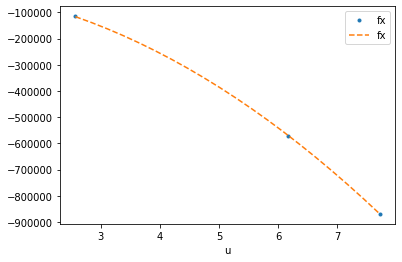

In [8]:
df_resistance = df_VCT.groupby(by='test type').get_group('resistance')

X = df_resistance[['u','fx']].copy()
X['u**2'] = X['u']**2
y = X.pop('fx')

model_resistance = sm.OLS(y,X)
results_resistance = model_resistance.fit()

X_pred = pd.DataFrame()
X_pred['u'] = np.linspace(X['u'].min(), X['u'].max(), 20)
X_pred['u**2'] = X_pred['u']**2
X_pred['fx'] = results_resistance.predict(X_pred)

fig,ax=plt.subplots()
df_resistance.plot(x='u', y='fx', style='.', ax=ax)
X_pred.plot(x='u', y='fx', style='--', ax=ax);


In [9]:
df_VCT_0_resistance = df_VCT.copy()
df_VCT_0_resistance['u**2'] = df_VCT_0_resistance['u']**2
df_VCT_0_resistance['fx']-= results_resistance.predict(df_VCT_0_resistance[['u','u**2']])

## Load test

In [10]:
df_runs = mdl.runs()

In [11]:
#id=22773
#id=22616
#id=22774
id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]
df.sort_index(inplace=True)

In [12]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
angle1                                                               10.0
angle2                                                               10.0
beam                                                             0.946602
comment                                                        ZZ 10/10PS
date                                                           2020-09-24
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                    

In [13]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,z02d_gradient,psi1d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,1.0,2.146755,0.000930,0.244419,0.0,-0.520477,10.131507,1.0,2.146755,-0.024623,0.122683,0.0,2.144633,11.329219,-0.000651,-0.009621,-0.007185,-0.002344,0.006963,0.008156,9.597722,5.567396,-0.113822,9.546612,5.328476,0.104278,-0.000007,0.645772,14.89,-0.005037,0.1,0.0,0.000025,0.000927,0.000325,-0.000873,7.611185,-0.001594,0.002499,1.020600,-0.003508,-0.022730,1.867924,0.017441,7.630116,0.932272,0.000005,-0.001617,0.000065,-6.810068e-07,-0.000821,0.000001,-0.000004,0.932272,0.000830,-0.022730,0.000005,-6.766628e-07,1.867924,0.000001,-0.000004,-0.000890
0.010007,0.0,1.0,2.146755,0.000832,0.121932,0.0,-0.288911,10.131507,1.0,2.146755,-0.022034,0.126699,0.0,1.025401,11.329219,0.012245,-0.012845,-0.014928,-0.012007,0.019213,0.003000,9.572657,5.679435,-0.110951,9.558256,5.397689,0.106811,-0.000007,0.645772,14.89,-0.004507,0.1,0.0,0.000025,0.000972,-0.000254,-0.000698,7.621398,-0.001629,0.002271,0.508139,0.000864,-0.004038,1.308212,0.013081,7.625826,0.921355,-0.002257,-0.001613,0.000114,-1.514633e-05,-0.000735,-0.000025,-0.000024,0.921354,0.000791,-0.004038,-0.002257,-1.680414e-05,1.308212,-0.000025,-0.000024,-0.000859
0.020011,0.0,1.0,2.146755,0.000736,-0.120384,0.0,0.000545,10.131507,1.0,2.146755,-0.019471,0.025530,0.0,1.913068,11.329219,-0.001296,-0.012200,-0.029125,0.002810,0.021792,0.002356,9.514150,5.728091,-0.107321,9.562515,5.484805,0.109010,0.000000,0.645772,14.89,-0.003983,0.1,0.0,0.000025,0.000915,0.000341,-0.000611,7.621356,-0.001577,0.002418,0.952405,0.001934,0.003452,0.258792,-0.008754,7.627892,0.921396,-0.003307,-0.001587,0.000145,-2.490043e-05,-0.000702,-0.000131,-0.000054,0.921396,0.000792,0.003452,-0.003307,-2.722338e-05,0.258792,-0.000131,-0.000054,-0.000860
0.030001,0.0,1.0,2.146755,0.000638,-0.310377,0.0,0.521567,10.131507,1.0,2.146755,-0.016901,-0.089957,0.0,0.639459,11.329219,0.005152,-0.012845,-0.016219,-0.005565,0.007608,-0.001511,9.541821,5.700100,-0.104350,9.587783,5.548451,0.110168,0.000000,0.645772,14.89,-0.003457,0.1,0.0,0.000025,0.000945,-0.000327,-0.000873,7.640413,-0.001590,0.002341,1.483970,0.002393,0.001150,-0.262092,-0.008748,7.639433,0.923933,-0.002592,-0.001575,0.000151,-3.795793e-05,-0.000805,-0.000191,-0.000113,0.923932,0.000895,0.001150,-0.002592,-4.004497e-05,-0.262092,-0.000191,-0.000113,-0.000969
0.040001,0.0,1.0,2.146755,0.000549,-0.303348,0.0,0.463676,10.131507,1.0,2.146755,-0.014543,-0.130523,0.0,-0.749933,11.329219,0.007087,-0.017357,-0.023318,-0.001700,0.017924,-0.002155,9.514368,5.613694,-0.103258,9.562679,5.586684,0.110073,0.000000,0.645772,14.89,-0.002975,0.1,0.0,0.000025,0.000929,0.000426,-0.000785,7.651012,-0.001529,0.002441,0.931076,0.003854,-0.001788,0.240757,-0.000002,7.649572,0.924786,-0.002156,-0.001540,0.000128,-4.577976e-05,-0.000809,-0.000182,-0.000150,0.924785,0.000876,-0.001788,-0.002156,-4.752416e-05,0.240757,-0.000182,-0.000150,-0.000948


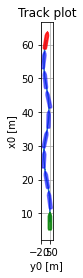

In [14]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

# Ship parameters

In [15]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : 0,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship

# VCT to prime system

In [16]:
interesting = [
    'u',
    'v',
    'r',
    'delta',
    'fx',
    'fy',
    'mz',
    'thrust',
]
df_VCT_prime = ps_ship.prime(df_VCT_0_resistance[interesting], U=df_VCT_0_resistance['V'])

In [17]:
df_VCT_prime.describe()

,u,v,r,delta,fx,fy,mz,thrust
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.0
mean,0.996958,-0.052229,-0.090617,-0.012120,-0.000033,0.000321,0.000326,0.0
std,0.004359,0.058503,0.141170,0.089367,0.000057,0.001123,0.000386,0.0
min,0.984808,-0.173648,-0.500000,-0.261799,-0.000229,-0.001346,-0.000413,0.0
25%,0.994522,-0.104528,-0.199056,-0.000000,-0.000062,-0.000541,0.000087,0.0
50%,0.998782,-0.034878,0.000000,-0.000000,-0.000009,0.000073,0.000241,0.0
75%,1.000000,0.000000,0.000000,0.000000,0.000001,0.001122,0.000565,0.0
max,1.000000,-0.000000,0.000000,0.226893,0.000031,0.002374,0.001345,0.0


# Linear Vessel Manoeuvring Model (VMM)
Implementing according to:
Matusiak, Jerzy. Dynamics of a Rigid Ship. Aalto University, 2017. https://aaltodoc.aalto.fi:443/handle/123456789/24408.

## N
The yaw is described by the following Ordinary Differential Equation (ODE):

In [18]:
Math(vlatex(eq.N_eq))

<IPython.core.display.Math object>

The hydrodynamic moment part of this model is:

In [19]:
Math(vlatex(eq.mz_eq))

<IPython.core.display.Math object>

In [20]:
N_eq = eq.mz_eq.copy()
N_eq = N_eq.subs([
    (x_G,0),  # Assuming or moving to CG=0
    #(I_z,1),  # Removing inertia
    #(eq.p.Nrdot,0),  # Removing added mass
    
    (u.diff(),0),
    (v.diff(),0),
    (r.diff(),0),

    
])  

#solution = sp.solve(N_eq,r.diff())[0]
#N_eq = sp.Eq(r.diff(), solution*(I_z-eq.p.Nrdot))  # Putting r1d on the LHS

In [21]:
#Math(vlatex(N_eq))

In [22]:
diff_eq_N = regression.DiffEqToMatrix(ode=N_eq, label=N_lin, base_features=[delta,u,v,r])

If accelerations (dotted states) are dropped from this equation, the quasi-static force model is obtained:

In [23]:
Math(vlatex(diff_eq_N.acceleration_equation))

<IPython.core.display.Math object>

This is a model that now only depend on steady velocities and rudder angle and will be the same thing as the forces/moment coming from the VCT calculations (CFD):

$ m_{z}^{VCT} = N_{lin} $

The hydrodynamic derivatives (the parameters in the matematical model) can be regressed by solving the following linear regression problem:

$ y = X \cdot \beta + \epsilon $

Where $y$ and $X$ and $\beta$ are:

In [24]:
Math(vlatex(diff_eq_N.acceleration_equation_x))

<IPython.core.display.Math object>

In [25]:
Math(vlatex(diff_eq_N.eq_y))

<IPython.core.display.Math object>

In [26]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[N_{\delta}],
[     N_{r}],
[     N_{u}],
[     N_{v}]]))

In [27]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [28]:
diff_eq_N.X_lambda

<function _lambdifygenerated(delta, r, u, v)>

In [29]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X.copy()
    X_['y'] = y
    X_.sort_values(by='y', inplace=True)
        
    y_ = X_.pop('y')
    
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    #ax.plot(X_.index,y_, label='Numerical gradient from model test')
    #ax.plot(X_.index,y_pred, '--', label='OLS')
    
    ax.plot(y_,y_pred, '.')
    ax.plot([y_.min(),y_.max()], [y_.min(),y_.max()], 'r-')
    
    ax.set_ylabel(f'{label} (prediction)')    
    ax.set_xlabel(label)
    
    ax.fill_between(y_, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5% confidence')
    ax.legend();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mz   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              1051.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):                    1.89e-33
Time:                        08:00:35   Log-Likelihood:                          310.40
No. Observations:                  36   AIC:                                     -612.8
Df Residuals:                      32   BIC:                                     -606.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta        -0.0026      0.000    -26.455      0.000      -0.003      -0.002
Nr            -0.0026   5.86e-05    -45.023      0.000      -0.003      -0.003
Nu         -4.849e-05    1.4e-05     -3.460      0.002    -7.7e-05   -1.99e-05
Nv            -0.0020      0.000    -12.675      0.000      -0.002      -0.002
==============================================================================
Omnibus:                        4.736   Durbin-Watson:                   1.394
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                3.474
Skew:                           0.499   Prob(JB):                        0.176
Kurtosis:                       4.149   Cond. No.                         21.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

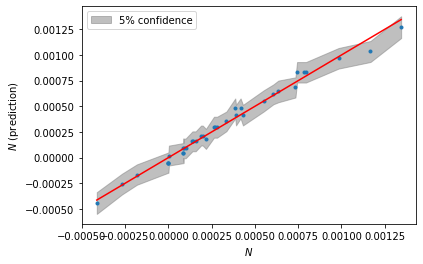

In [30]:
X = diff_eq_N.calculate_features(data=df_VCT_prime)
y = diff_eq_N.calculate_label(y=df_VCT_prime['mz'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$N$')

## Y

In [31]:
Math(vlatex(sp.solve(eq.Y_eom,Y_lin)))

<IPython.core.display.Math object>

In [32]:
Math(vlatex(eq.Y_eom))

<IPython.core.display.Math object>

In [33]:
Math(vlatex(eq.fy_eq))

<IPython.core.display.Math object>

In [34]:
Y_eq = eq.fy_eq.copy()
Y_eq = Y_eq.subs([
    #(eq.p.Yvdot,1),  # Removing added mass
    (x_G,0),  
    (u.diff(),0),
    (v.diff(),0),
    (r.diff(),0),
    
])  
#solution = sp.solve(Y_eq,v.diff())[0]
#solution = solution*(-eq.p.Yvdot+m)
#solution = solution + U*m*r# (adding u*m*r to the measurement fy instead)  
#Y_eq = sp.simplify(sp.Eq(v.diff(), solution))  # Putting r1d on the LHS

In [35]:
Math(vlatex(Y_eq))

<IPython.core.display.Math object>

In [36]:
diff_eq_Y = regression.DiffEqToMatrix(ode=Y_eq, label=Y_lin, base_features=[delta,u,v,r])

In [37]:
diff_eq_Y.eq_beta

Eq(beta, Matrix([
[Y_{\delta}],
[     Y_{r}],
[     Y_{u}],
[     Y_{v}]]))

In [38]:
diff_eq_Y.acceleration_equation_x

Eq(y, Y_{\delta}*x_1 + Y_{r}*x_2 + Y_{u}*x_3 + Y_{v}*x_4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fy   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              1185.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):                    2.83e-34
Time:                        08:00:36   Log-Likelihood:                          282.55
No. Observations:                  36   AIC:                                     -557.1
Df Residuals:                      32   BIC:                                     -550.8
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ydelta         0.0044      0.000     20.359      0.000       0.004       0.005
Yr             0.0024      0.000     18.545      0.000       0.002       0.003
Yu            -0.0001   3.04e-05     -3.563      0.001      -0.000   -4.64e-05
Yv            -0.0133      0.000    -39.314      0.000      -0.014      -0.013
==============================================================================
Omnibus:                        4.535   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                1.772
Skew:                          -0.053   Prob(JB):                        0.412
Kurtosis:                       1.918   Cond. No.                         21.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

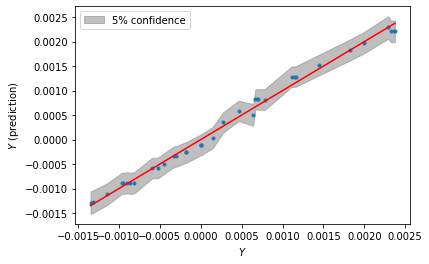

In [39]:
X = diff_eq_Y.calculate_features(data=df_VCT_prime, simplify_names=True)
y = diff_eq_Y.calculate_label(y=df_VCT_prime['fy'])
#y+=df['u']*df['r']  # adding centrifugal force

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$Y$')

In [40]:
X.head()

,Ydelta,Yr,Yu,Yv
494,-0.000000,0.0,1.0,-0.0
495,-0.000000,0.0,1.0,-0.0
496,-0.000000,0.0,1.0,-0.0
497,-0.174533,0.0,1.0,-0.0
498,-0.226893,0.0,1.0,-0.0


## X

In [41]:
X_eq = eq.fx_eq.copy()
X_eq = X_eq.subs([
    #(eq.p.Xudot,1),  # Removing added mass
    (u.diff(),0),
    (v.diff(),0),
    (r.diff(),0),
    #(m,0),  # mass
    
])  

#solution = sp.solve(X_eq,u.diff())[0]
#X_eq = sp.Eq(u.diff(), solution*(-eq.p.Xudot+m))  # Putting r1d on the LHS

In [42]:
Math(vlatex(X_eq))

<IPython.core.display.Math object>

In [43]:
diff_eq_X = regression.DiffEqToMatrix(ode=X_eq, label=X_lin, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fx   R-squared (uncentered):                   0.302
Model:                            OLS   Adj. R-squared (uncentered):              0.215
Method:                 Least Squares   F-statistic:                              3.463
Date:                Tue, 06 Jul 2021   Prob (F-statistic):                      0.0185
Time:                        08:00:37   Log-Likelihood:                          302.18
No. Observations:                  36   AIC:                                     -596.4
Df Residuals:                      32   BIC:                                     -590.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xdelta      6.376e-05      0.000      0.507      0.616      -0.000       0.000
Xr         -3.527e-05   7.37e-05     -0.479      0.635      -0.000       0.000
Xu          -2.46e-05   1.76e-05     -1.397      0.172   -6.05e-05    1.13e-05
Xv             0.0002      0.000      1.101      0.279      -0.000       0.001
==============================================================================
Omnibus:                       21.003   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.150
Skew:                          -1.669   Prob(JB):                     4.68e-07
Kurtosis:                       5.879   Cond. No.                         21.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

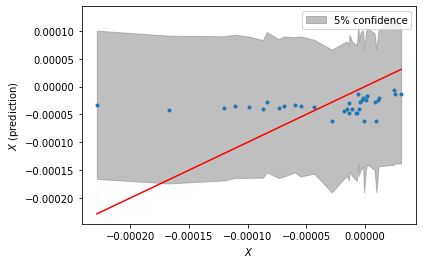

In [44]:
X = diff_eq_X.calculate_features(data=df_VCT_prime)
y = diff_eq_X.calculate_label(y=df_VCT_prime['fx'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$X$')

In [45]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

# Brix parameters

In [46]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)

mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)
df_parameters.loc['Ydelta','brix_prime'] = 0.005  # Just guessing
df_parameters.loc['Ndelta','brix_prime'] = -df_parameters.loc['Ydelta','brix_prime']/2  # Just guessing
df_parameters['brix_prime'].fillna(0, inplace=True)

## Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [47]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'coeff':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['prime'] = df_parameters_all['regressed'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

In [48]:
df_parameters_all

,$P_{value}$,$conf_{higher}$,$conf_{lower}$,brix,brix_prime,regressed,coord,dof,state,symbol,prime
Ndelta,2.548870e-23,-0.002445,-0.002853,NaN,-0.002500,-0.002649,\delta,N,,N_{\delta},-0.002649
Ndeltadot,NaN,NaN,NaN,NaN,0.000000,NaN,\delta,N,dot,N_{\dot{\delta}},0.000000
Nr,1.632364e-30,-0.002520,-0.002758,-pi*T**2*(0.039*B/T - 0.56*B/L + 0.25)/L**2,-0.001719,-0.002639,r,N,,N_{r},-0.002639
Nrdot,NaN,NaN,NaN,-pi*T**2*(0.017*B*CB/T - 0.33*B/L + 0.08333333...,-0.000299,NaN,r,N,dot,N_{\dot{r}},-0.000299
Nu,1.551268e-03,-0.000020,-0.000077,NaN,0.000000,-0.000048,u,N,,N_{u},-0.000048
Nudot,NaN,NaN,NaN,NaN,0.000000,NaN,u,N,dot,N_{\dot{u}},0.000000
Nv,5.111820e-14,-0.001664,-0.002301,-pi*T**2*(0.5 + 2.4*T/L)/L**2,-0.003184,-0.001982,v,N,,N_{v},-0.001982
Nvdot,NaN,NaN,NaN,-pi*T**2*(-0.04*B/T + 1.1*B/L)/L**2,-0.000128,NaN,v,N,dot,N_{\dot{v}},-0.000128
Xdelta,6.158511e-01,0.000320,-0.000193,NaN,0.000000,0.000064,\delta,X,,X_{\delta},0.000064
Xdeltadot,NaN,NaN,NaN,NaN,0.000000,NaN,\delta,X,dot,X_{\dot{\delta}},0.000000


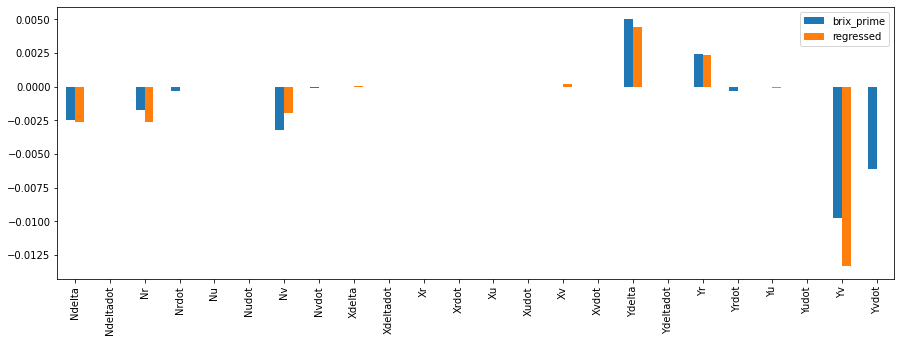

In [49]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)
df_parameters_all.plot.bar(y=['brix_prime','regressed'], ax=ax);

It seems that the regressed hydrodynamic derivatives are reasonable similar to the corresponding predicted values with semi-empirical formulas from Brix.

# Simulation

<AxesSubplot:xlabel='time'>

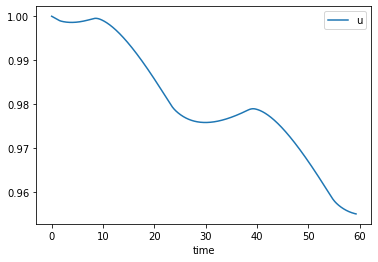

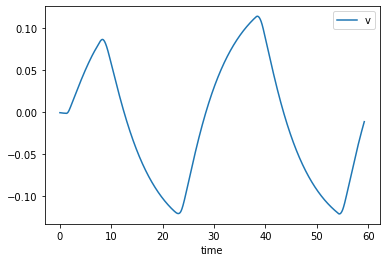

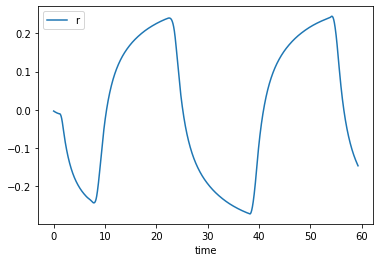

In [50]:
df_ = df.copy()
t = df_.index
control = df_[['delta']]
#control = {'delta':0,}

df_0 = df_.iloc[0:100].median(axis=0)
y0 = {
    'u' : df_0['u'], 
    'v' : df_0['v'],
    'r' : df_0['r'],
    'x0' : df_0['x0'],
    'y0' : df_0['y0'],
    'psi' : df_0['psi'],
    }

#solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, df_ship_parameters=df_ship_parameters, control=control, rtol=1e-3, atol=1e-3)
solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters_all, ship_parameters=ship_parameters, control=control)

columns = list(y0.keys())
df_result_prime = pd.DataFrame(data=solution.y.T, columns=columns)
df_result_prime.index=t[0:len(df_result_prime)]

#df_result_prime['U'] = np.sqrt(df_result_prime['u']**2 + df_result_prime['v']**2)

df_result_prime.plot(y='u')
df_result_prime.plot(y='v')
df_result_prime.plot(y='r')


In [51]:
U_ = np.sqrt(df_0['u']**2 + df_0['v']**2)
df_result = ps.unprime(values=df_result_prime, U=U_)
df_result['beta'] = -np.arctan2(df_result['v'],df_result['u'])

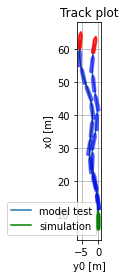

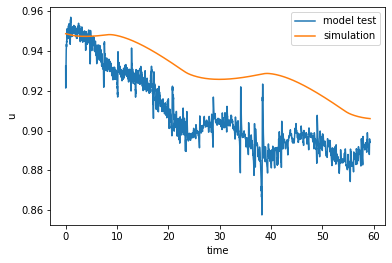

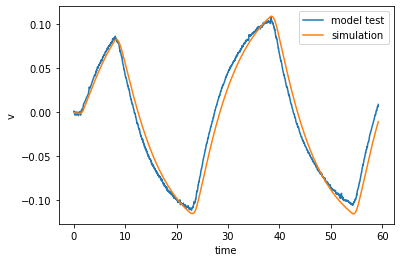

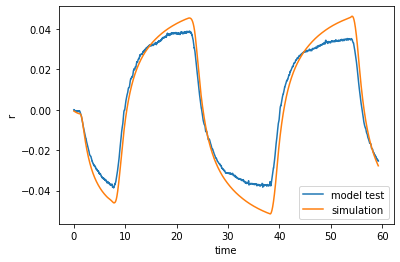

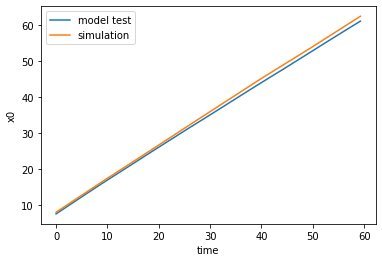

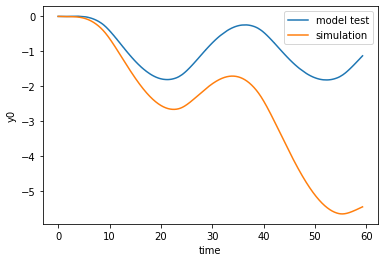

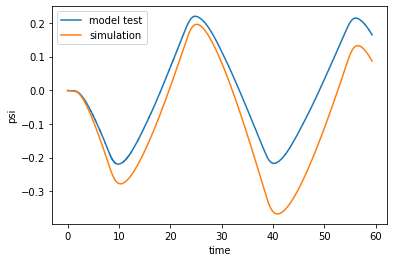

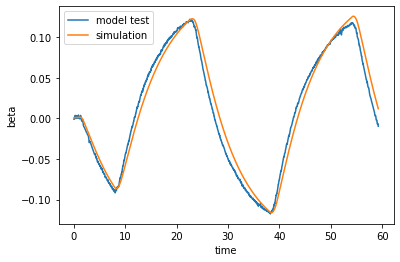

In [52]:
fig,ax=plt.subplots()
track_plot(df=df, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='model test')
track_plot(df=df_result, lpp=ship_parameters['L'], beam=ship_parameters['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result:
    fig,ax = plt.subplots()
    df.plot(y=key, label='model test', ax=ax)
    df_result.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)

